# Artificial Neural Network

* understand the basic Image Classification pipeline using Multi-layered Neural Network
* understand the train/val/test splits and the use of validation data for hyperparameter tuning.
* develop proficiency in writing efficient vectorized code with numpy
* implement and apply various classic activation functions
* implement and apply mini-batch gradient descent
* implement and apply regularization
* implement and apply hyperparameter finetuning strategy
* understand the differences and tradeoffs between these classifiers
* the use of feature extraction to boost neural net performance

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=7)

# [Part 1] Binary Single Layer Perceptron

## 1 - Load Dataset

For this exercise, we will use binary class data to recognize `cats` and `not cats`. 
The images are $64\times64$ in dimension.

---
### a. Load Cat Dataset
first, load the dataset

In [2]:
import h5py

def load_dataset():
    dataset = h5py.File('catvnoncat.h5', "r")
    
    train_set_x_orig = np.array(dataset["X_train"][:])
    train_set_y_orig = np.array(dataset["y_train"][:])
    val_set_x_orig = np.array(dataset["X_val"][:])
    val_set_y_orig = np.array(dataset["y_val"][:])
    classes = np.array(dataset["classes"][:])
    
    return train_set_x_orig, train_set_y_orig, val_set_x_orig, val_set_y_orig, classes

In [3]:
X_train_ori, y_train, X_val_ori, y_val, classes = load_dataset()

In [4]:
print(X_train_ori.shape)
print(y_train.shape)
print(X_val_ori.shape)
print(y_val.shape)

(209, 64, 64, 3)
(209, 1)
(50, 64, 64, 3)
(50, 1)


View some data

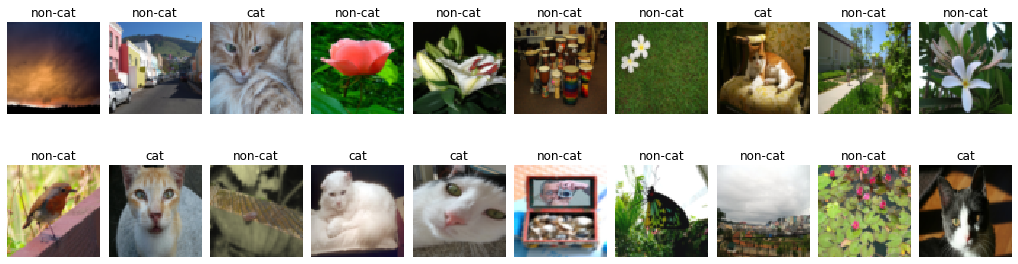

In [5]:
fig, ax = plt.subplots(2, 10, figsize=(18,5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for j in range(0, 2):
    for i in range(0, 10):
        ax[j,i].imshow(X_train_ori[i+j*10])
        ax[j,i].set_title(classes[y_train[i+j*10, 0]].decode("utf-8"))
        ax[j,i].axis('off')
plt.show()

---
### b. Reshape and Normalize Data

In [6]:
X_train = np.reshape(X_train_ori, (X_train_ori.shape[0], 
                                   X_train_ori.shape[1]*X_train_ori.shape[2]*X_train_ori.shape[3]))
X_val = np.reshape(X_val_ori, (X_val_ori.shape[0], 
                               X_val_ori.shape[1]*X_val_ori.shape[2]*X_val_ori.shape[3]))

In [7]:
print('before')
print(X_train_ori.shape)
print(X_val_ori.shape)

print('\nafter')
print(X_train.shape)
print(X_val.shape)

before
(209, 64, 64, 3)
(50, 64, 64, 3)

after
(209, 12288)
(50, 12288)


* Since for this dataset using sigmoid and regression is enough, 
* standarize the dataset into a `range of 0-1` by dividing it with `255`

In [8]:
X_train = X_train/255.
X_val = X_val/255.

In [9]:
print('after',X_train[0,:6])

after [0.0666667 0.1215686 0.2196078 0.0862745 0.1294118 0.2313725]


---
## 2 - Basic Neurons

Standard neuron is basically the same as previous linear function. 

---
### a. Forward and Backward Affine Function

    * Implement Affine forward function:

$$
\begin{align}
f(x, W, b) = x.W + b
\end{align}
$$

In [10]:
def affine_forward(x, W, b):  
    return x.dot(W)+b

    * Implement affine backward function:


$$
\begin{align*}
\partial W & = x^T.\partial out \\
\partial b & = \sum \partial out \\
\partial x & = \partial out.W^T \\
\end{align*}
$$

In [11]:
def affine_backward(dout, x, W, b):
    dW = (x.T).dot(dout)
    db = np.sum(dout, axis=0, keepdims=True)
    dx = dout.dot(W.T)
    return dW, db, dx

---
### b. Forward and Backward Sigmoid Function
Also implement the activation function

    * Implement Sigmoid forward function:

$$
\begin{align}
f(x) = \sigma(x) = \frac{1}{1+e^{-v}}
\end{align}
$$


In [12]:
def sigmoid_forward(x):  
    return 1/(1+(np.e**(-x)))

Check your implementation

In [13]:
x = np.array([-2, -1, 0, 1, 2, 3])
ds = sigmoid_forward(x)

print(ds)

[0.1192029 0.2689414 0.5       0.7310586 0.8807971 0.9525741]


---    
    * Implement Sigmoid backward function
$$
\begin{align*}
\sigma'(x) = \sigma(x) \ (1 - \sigma(x))\\\\
\partial out = \partial out . \sigma'(x)
\end{align*}
$$
<br>

In [14]:
def sigmoid_backward(dout, ds):
    """
    Argument:
        ds: sigmoid forward result
        dout: gradient error
    """
    
    # calculate the local gradient of sigmoid
    ds_prime = ds*(1-ds)
    
    # calculate the gradient propagation
    dout = dout*ds_prime
    return dout

Check your implementation

In [15]:
np.random.seed(10)
dout = np.random.random((6,)) 
dout = sigmoid_backward(dout, ds)
print(dout)

[0.0809837 0.0040801 0.1584121 0.1472238 0.05234   0.0101556]


---
### c. Forward and Backward Tanh Function
    * Implement `Tanh` forward function

**hint: use `np.tanh(x)`*

$$
\begin{align}
f(x) = tanh(x)
\end{align}
$$

In [16]:
def tanh_forward(x):  
    return np.tanh(x)

Check your implementation

In [17]:
x = np.array([-2, -1, 0, 1, 2, 3])
dt = tanh_forward(x)

print(dt)

[-0.9640276 -0.7615942  0.         0.7615942  0.9640276  0.9950548]


---
    * Implement Tanh backward function
$$
\begin{align*}
f'(x) = 1-f(v)^2\\
\\
\partial out = \partial out . f'(x)
\end{align*}
$$
<br>

In [18]:
def tanh_backward(dout, dt):
    """
    Argument:
        dt: tanh forward result
        dout: gradient error
    """
    
    # calculate the local gradient of tanh
    dt_prime = 1-dt**2
    
    # calculate the gradient propagation
    dout = dout*dt_prime
    
    return dout

Check your implementation

In [19]:
np.random.seed(10)
dout = np.random.random((6,)) 
dout = tanh_backward(dout, dt)
print(dout)

[0.0544944 0.0087153 0.6336482 0.3144784 0.0352199 0.0022179]


---
### d. Forward and Backward ReLU Function

Next we implement ReLU activation function

We haven't discussed aboout activation function yet in class, but the implementation of these functions are quite easy, so you should be able to handle it

* Implement ReLU forward function:


$$
\begin{align}
f(x) = 
\begin{cases}
0, & \text{for } x<0\\
x, & \text{for } x\geq0
\end{cases}
\end{align}
$$

**hint: use `np.maximum()`*

In [20]:
def relu_forward(x): 
  
    out = np.maximum(0, x)
    
    return out

Check your implementation

In [21]:
x = np.array([-2, -1, 0, 1, 2, 3])
dr = relu_forward(x) 

print(dr)

[0 0 0 1 2 3]


---
* Implement ReLU backward function
$$
\begin{align*}
f'(v) = 
\begin{cases}
0, & \text{for } x<0\\
1, & \text{for } x\geq0
\end{cases}\\
\\
\partial out = \partial out . f'(x)
\end{align*}
$$

**hint: use `np.where(condition, if true, if false)`*

In [22]:
def relu_backward(dout, x):
    """
    Argument:
        x: relu input
        dout: gradient error
    """
    
    # calculate the local gradient of relu
    dr_prime = np.where(x<=0, 0, 1)
    
    # calculate the gradient propagation
    dout = dout*dr_prime
    
    return dout

Check your implementation

In [23]:
np.random.seed(10)
dout = np.random.random((6,)) 
dout = relu_backward(dout, x)
print(dout)

[0.        0.        0.        0.7488039 0.498507  0.2247966]


---
## 3 - One-Layer Sigmoid

We'll train a Single Layer Perceptron with Sigmoid for binary Classification using Full batch **Gradient Descent**


### a. Training Function

The network architecture should be: <br>
<pre><font color="blue"><b>Input - FC layer - Sigmoid</b></font></pre>

Implement Training Function

    * call affine forward function
    * call sigmoid forward function
    * apply L2 loss regression (MSE)
    * call affine backward function
    * implement weight update

<br>

**Note** that we do not calculate `sigmoid backward` as in Single Layer Perceptron `sigmoid` is used directly as output activation

In [24]:
def train_one_layer(X, y, W=None, b=None, lr=0.005, epochs=100, verbose=True):
    
    
    num_train, dim = X.shape
    
    num_classes = 1
    
    # initialize weights if not provided
    if W is None:
        W = 0.02*np.random.rand(dim, num_classes)
    if b is None:
        b = np.zeros((1, num_classes))

    # Run stochastic gradient descent to optimize W
    loss_history = []
                     
    for ep in range(epochs):
        

        # calculate 1st layer score by calling affine forward function using X, W, and b
        layer1 = affine_forward(X, W, b)
        
        # calculate 1st activation score by calling sigmoid forward function using layer1 score
        act1 = sigmoid_forward(layer1)
        
        # calculate error by subtracting act1 with y
        error = act1-y
        
        # calculate L2 Loss (MSE) by averaging the squared error (mean)
        loss = np.mean(error**2)
        
        # divide error by num_train
        error /= num_train
    
        # calculate layer 1 weights gradient by calling affine backward function using error, X, W, and b
        dW, db, _ = affine_backward(error, X, W, b)

        
        # perform parameter update by subtracting each W and b with a fraction of dW and db
        # according to the learning rate
        W -= lr*dW
        b -= lr*db

        if verbose and ep % 100 == 0:
            print ('epoch',ep,'/',epochs, ': loss =', loss)
            
            # append the loss history
            loss_history.append(loss)

    print('Training done')
    
    return W, b, loss_history

### b. Train the Binary Classifier

Try the training Function using the initial parameter

In [25]:
W, b, loss = train_one_layer(X_train, y_train, epochs=2000, lr=0.005)

epoch 0 / 2000 : loss = 0.6554838533139654
epoch 100 / 2000 : loss = 0.21883203554667116
epoch 200 / 2000 : loss = 0.1612961378750308
epoch 300 / 2000 : loss = 0.1134096477432929
epoch 400 / 2000 : loss = 0.09326197928096298
epoch 500 / 2000 : loss = 0.08250527006724967
epoch 600 / 2000 : loss = 0.07380234349511444
epoch 700 / 2000 : loss = 0.06657927073121864
epoch 800 / 2000 : loss = 0.060474156800466514
epoch 900 / 2000 : loss = 0.05523946194103321
epoch 1000 / 2000 : loss = 0.050698496532507444
epoch 1100 / 2000 : loss = 0.04672110598567046
epoch 1200 / 2000 : loss = 0.04320899221227414
epoch 1300 / 2000 : loss = 0.04008635310135497
epoch 1400 / 2000 : loss = 0.03729366428242084
epoch 1500 / 2000 : loss = 0.03478341829136955
epoch 1600 / 2000 : loss = 0.03251713466022676
epoch 1700 / 2000 : loss = 0.03046322218595562
epoch 1800 / 2000 : loss = 0.02859542674633686
epoch 1900 / 2000 : loss = 0.026891688892654114
Training done


Visualize the loss

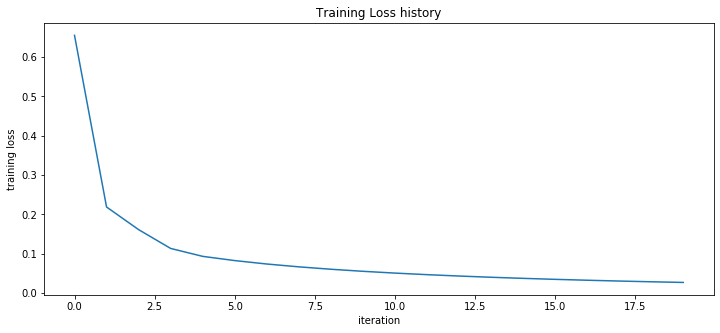

In [26]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.plot(loss)
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()


### c. Predict Function

The network architecture should be: <br>
<pre><font color="blue"><b>Input - FC layer - Sigmoid</b></font></pre>

Implement Predict Function

    * call forward function

In [27]:
def predict_one_layer(X, W, b):    
    y_pred = np.zeros(X.shape[1])
    
    # calculate 1st layer score by calling affine forward function using X, W, and b
    layer1 = affine_forward(X, W, b)

    # calculate 1st activation score by calling sigmoid forward function using layer1 score
    act1 = sigmoid_forward(layer1)
    
    # since it's a binary class, round the score to get the class
    y_pred = np.round(act1)
    
    return y_pred

### d. Training Accuracy
Calculate the Training Accuracy

In [28]:
import sklearn
from sklearn.metrics import accuracy_score

y_pred = predict_one_layer(X_train, W, b)
accuracy = sklearn.metrics.accuracy_score(y_train, y_pred)

print('Training Accuracy =',accuracy*100,'%')

print('Training label  =',y_train[:15].ravel())
print('Predicted label =',y_pred[:15].astype('int').ravel())

Training Accuracy = 99.04306220095694 %
Training label  = [0 0 1 0 0 0 0 1 0 0 0 1 0 1 1]
Predicted label = [0 0 1 0 0 0 0 1 0 0 0 1 0 1 1]


Calculate the Validation Accuracy

In [29]:
y_pred = predict_one_layer(X_val, W, b)
accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)
print('Validation Accuracy =', accuracy*100,'%')

print('Validation label =',y_val[:15].ravel())
print('Predicted label  =',y_pred[:15].astype('int').ravel())

Validation Accuracy = 74.0 %
Validation label = [1 1 1 1 1 0 1 1 1 1 1 1 1 0 0]
Predicted label  = [1 1 1 1 1 1 0 1 1 1 0 1 1 1 0]


---
---
# [Part 2] Multi-Layered Perceptron

Now, let's build some multi-layered Neural Networks and train it using CIFAR-10 dataset

---
## 1 - Load CIFAR-10 Dataset

CIFAR-10 dataset is a image classification dataset, consisting of 10 classes. 

The images are $32\times32$ color image with 50,000 data train and 10,000 data test

---
### a. Import Data CIFAR-10

In [30]:
import tensorflow as tf

(X_train_ori, y_train_ori), (X_test_ori, y_test_ori) = tf.keras.datasets.cifar10.load_data()
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print('X_train.shape =',X_train_ori.shape)
print('y_train.shape =',y_train_ori.shape)
print('X_test.shape  =',X_test_ori.shape)
print('y_test.shape  =',y_test_ori.shape)

X_train.shape = (50000, 32, 32, 3)
y_train.shape = (50000, 1)
X_test.shape  = (10000, 32, 32, 3)
y_test.shape  = (10000, 1)


---
### b. Visualizing Data
Show the first 20 images from `X_train`

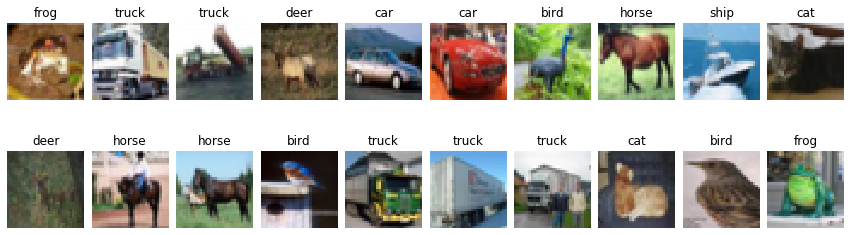

In [31]:
fig, ax = plt.subplots(2,10,figsize=(15,4.5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
for j in range(0,2):
    for i in range(0, 10):
        ax[j,i].imshow(X_train_ori[i+j*10])
        ax[j,i].set_title(classes[y_train_ori[i+j*10,0]])
        ax[j,i].axis('off')
plt.show()

---
### c. Split Training Data

Get the last 1000 data from Training Set as Validation Set

In [32]:
X_val = X_train_ori[-1000:,:]
y_val = y_train_ori[-1000:]

X_train = X_train_ori[:-1000, :]
y_train = y_train_ori[:-1000]

X_test = X_test_ori
y_test = y_test_ori

print('X_val.shape   =',X_val.shape)
print('y_val.shape   =',y_val.shape)
print('X_train.shape =',X_train.shape)
print('y_train.shape =',y_train.shape)

X_val.shape   = (1000, 32, 32, 3)
y_val.shape   = (1000, 1)
X_train.shape = (49000, 32, 32, 3)
y_train.shape = (49000, 1)


---
### d. Normalizing Data
Normalize `X_train`, `X_val` and `X_test` by *zero-centering* them:

In [33]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

mean_image = np.mean(X_train, axis = 0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

print('np.mean(X_train) =',np.mean(X_train))
print('np.mean(X_val)   =',np.mean(X_val))
print('np.mean(X_test)  =',np.mean(X_test))

np.mean(X_train) = -6.6769658e-06
np.mean(X_val)   = 0.89910334
np.mean(X_test)  = 0.83958524


---
### e. Reshape Data
Reshape each data in `X_train`, `X_val` and `X_test` into 1-dimensional matrix

In [34]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
X_val = X_val.reshape((X_val.shape[0],X_val.shape[1]*X_val.shape[2]*X_val.shape[3]))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]*X_test.shape[3]))

print('X_train.shape =',X_train.shape)
print('X_val.shape   =',X_val.shape)
print('X_test.shape  =',X_test.shape)

X_train.shape = (49000, 3072)
X_val.shape   = (1000, 3072)
X_test.shape  = (10000, 3072)


 Reshape `y_train`, `y_val` and `y_test` into a vector 

In [35]:
y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()

print('y_train.shape =',y_train.shape)
print('y_val.shape   =',y_val.shape)
print('y_test.shape  =',y_test.shape)

y_train.shape = (49000,)
y_val.shape   = (1000,)
y_test.shape  = (10000,)


---
## 2 - Softmax Function 

### a. Softmax Score

In [36]:
def softmax(x):  
    
    # shift x by subtracting with its maximum value . Use np.max(...)
    x -= np.max(x)
    
    # Apply exp() element-wise to x. Use np.exp(...).    
    x_exp = np.exp(x)
    
    # Create a vector X_sum that sums each row of X_exp. Use np.sum(..., axis = 1, keepdims = True).
    x_sum = np.sum(x_exp, axis = 1, keepdims = True)  
    
    # Compute softmax(x) score by dividing X_exp by X_sum. It should automatically use numpy broadcasting.
    score = x_exp / x_sum
    
    return score

### b. Softmax Loss

In [37]:
def softmax_loss(score, y):
   
    num_examples = score.shape[0]
    
    #make a number list containing [1 2 3 ... n]
    number_list = range(num_examples)
    
    # calculate the correct log probability of score[number_list,y] by applycing -np.log(...)
    corect_logprobs = -np.log(score[number_list,y])
    
    # average the correct log probability, use np.sum then divide it by num_examples
    loss = np.sum(corect_logprobs)/num_examples
    
    
    # 3. COMPUTE THE GRADIENT ON SCORES
    dscores = score
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    
    return loss, dscores

---
## 3 - Two-Layered Sigmoid with Softmax

---

### a. Training Function

The network architecture should be: 
<pre><font color="blue"><b>Input - FC layer - Sigmoid - FC Layer - Softmax</b></font></pre>

Implement Training Function

    * call affine forward function
    * call sigmoid forward function
    * call affine forward function
    
    * call softmax function
    * call softmax_loss function
    
    * call affine backward function
    * call sigmoid backward function
    * call affine backward function
    
    * implement weight update

In [38]:
def train_two_layer_sigmoid(X, y, hidden_size, W=None, b=None, 
                            lr=1e-4, lr_decay=0.9, reg=0.25, 
                            epochs=100, batch_size=200, verbose=True):
    num_train, dim = X.shape
    
    # check if data train is divisible by batch size
    assert num_train % batch_size==0, "data train "+str(num_train)+" is not divisible by batch size"+str(batch_size)
    
    # total iteration per epoch
    num_iter = num_train // batch_size
    
    #start iteration counts
    it = 0
    
    num_classes = np.max(y) + 1  # assume y takes values 0...K-1 where K is number of classes
    
    # initialize weights if not provided
    if W is None:
        W0 = 1e-4 * np.random.randn(dim, hidden_size)
        W1 = 1e-4 * np.random.randn(hidden_size, num_classes)
        W = [W0, W1]
    if b is None:
        b0 = np.zeros((1,hidden_size))
        b1 = np.zeros((1,num_classes))
        b = [b0, b1]

    # Run stochastic gradient descent to optimize W
    loss_history = []
                     
    for ep in range(epochs):
        # Shuffle data train index
        train_rows = np.arange(num_train)
        np.random.shuffle(train_rows)
        
        # split index into mini batches
        id_batch = np.split(train_rows, num_iter)
        
        for batch in id_batch:
          
            # get mini batch data and label
            X_batch = X[batch]
            y_batch = y[batch]


            # calculate 1st layer score by calling affine forward function using X_batch, W[0], and b[0]
            layer1 = affine_forward(X_batch, W[0], b[0])


            # calculate 1st activation score by calling sigmoid forward function using layer1 score
            act1 = sigmoid_forward(layer1)


            # calculate 2nd layer score by calling affine forward function using act1, W[1], and b[1]
            layer2 = affine_forward(act1, W[1], b[1])


            # calculate softmax score by calling softmax function using layer2 score
            softmax_score = softmax(layer2)


            # evaluate loss and gradient by calling softmax_loss function using softmax_score and y_batch
            loss, dout = softmax_loss(softmax_score, y_batch)


            # add regularization to the loss
            loss+= reg * (np.sum(W[0] * W[0]) + np.sum(W[1] * W[1]))

            # append the loss history
            loss_history.append(loss)

            # calculate layer 2 weights gradient by calling affine backward function using dout, act1, W[1], and b[1]
            dW1, db1, dact1 = affine_backward(dout, act1, W[1], b[1])


            # calculate sigmoid gradient by calling sigmoid backward function using dact1 and act1 score
            dlayer1 = sigmoid_backward(dact1, act1)


            # calculate layer 1 weights gradient by calling affine backward function using dlayer1, X_batch, W[0], and b[0]
            dW0, db0, _ = affine_backward(dlayer1, X_batch, W[0], b[0])


            # perform regulatization gradient
            dW1 += 2 * reg * W[1]
            dW0 += 2 * reg * W[0]

            # perform parameter update by subtracting W and b with a fraction of dW and db
            # according to the learning rate
            W[0] -= lr*dW0
            b[0] -= lr*db0
            W[1] -= lr*dW1
            b[1] -= lr*db1
        
            # iteration count
            it +=1

            if verbose and it % 100 == 0:
                print ('iteration',it,'(epoch', ep,'/',epochs, '): loss =', loss)
                
                
        # At the end of one epoch:
        # Decay learning rate
        lr *= lr_decay
            
    print('Training Done')
    return W, b, loss_history

---
### b. Train the Softmax Classifier

Try the training Function using the initial parameter

In [39]:
W_sigm, b_sigm, loss = train_two_layer_sigmoid(X_train, y_train, hidden_size=50, epochs=15)

iteration 100 (epoch 0 / 15 ): loss = 2.302905496997303
iteration 200 (epoch 0 / 15 ): loss = 2.3028122703546505
iteration 300 (epoch 1 / 15 ): loss = 2.3026162177766
iteration 400 (epoch 1 / 15 ): loss = 2.302191546391288
iteration 500 (epoch 2 / 15 ): loss = 2.3012546732508343
iteration 600 (epoch 2 / 15 ): loss = 2.3011760201493496
iteration 700 (epoch 2 / 15 ): loss = 2.2996405755827904
iteration 800 (epoch 3 / 15 ): loss = 2.2983765657368704
iteration 900 (epoch 3 / 15 ): loss = 2.2985628422890603
iteration 1000 (epoch 4 / 15 ): loss = 2.2968297510087208
iteration 1100 (epoch 4 / 15 ): loss = 2.2947910069172295
iteration 1200 (epoch 4 / 15 ): loss = 2.291988401904289
iteration 1300 (epoch 5 / 15 ): loss = 2.29105565837126
iteration 1400 (epoch 5 / 15 ): loss = 2.292219069665768
iteration 1500 (epoch 6 / 15 ): loss = 2.288109613438841
iteration 1600 (epoch 6 / 15 ): loss = 2.2872688906536003
iteration 1700 (epoch 6 / 15 ): loss = 2.2873759809301633
iteration 1800 (epoch 7 / 15 ): l

Visualize the loss

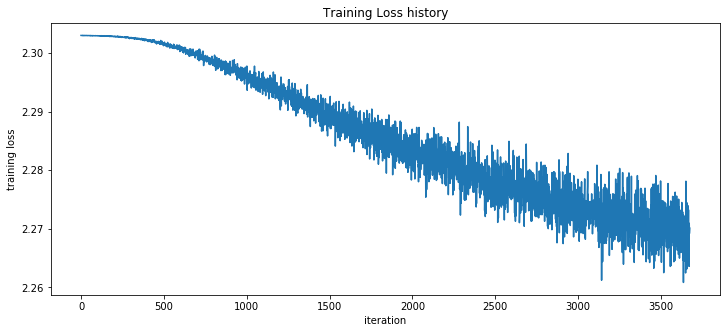

In [40]:
plt.rcParams['figure.figsize'] = [12, 5]
plt.plot(loss)
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

---
### c. Predict Function
Implement Predict function

The network architecture should be: 
<pre><font color="blue"><b>Input - FC layer - Sigmoid - FC Layer - argmax</b></font></pre>

Implement Predict Function

    * call affine forward function
    * call sigmoid forward function
    * call affine forward function
    * call argmax to get max score id

In [41]:
def predict_two_layer_sigmoid(X, W, b):    
    y_pred = np.zeros(X.shape[1])

    
    # calculate 1st layer score by calling affine forward function using X_batch, W[0], and b[0]
    layer1 = affine_forward(X, W[0], b[0])


    # calculate 1st activation score by calling sigmoid forward function using layer1 score
    act1 = sigmoid_forward(layer1)


    # calculate 2nd layer score by calling affine forward function using act1, W[1], and b[1]
    layer2 = affine_forward(act1, W[1], b[1])

    
    # take the maximum prediction from layer 2 and use that column to get the class   
    # use np.argmax with axis=-1 
    y_pred = np.argmax(layer2, axis=-1)

    
    return y_pred

### d. Training Accuracy
Calculate the Training Accuracy

In [42]:
import sklearn
from sklearn.metrics import accuracy_score

y_pred = predict_two_layer_sigmoid(X_train, W_sigm, b_sigm)
accuracy = sklearn.metrics.accuracy_score(y_train, y_pred)

print('Training Accuracy =',accuracy*100,'%')

print('Training label  =',y_train[:15])
print('Predicted label =',y_pred[:15])

Training Accuracy = 17.751020408163264 %
Training label  = [6 9 9 4 1 1 2 7 8 3 4 7 7 2 9]
Predicted label = [6 8 8 6 8 6 6 6 8 6 6 8 8 6 6]


In [43]:
y_pred = predict_two_layer_sigmoid(X_val, W_sigm, b_sigm)
accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)
print('Validation Accuracy =', accuracy*100,'%')

print('Validation label =',y_val[:15])
print('Predicted label  =',y_pred[:15])

Validation Accuracy = 18.9 %
Validation label = [8 9 4 9 0 5 0 8 2 3 7 8 9 4 5]
Predicted label  = [8 6 8 6 8 6 8 8 6 4 6 8 8 8 6]


---
## 4 - Two-Layer ReLU with Softmax

Now we implement Two-Layer Neural Network, but this time we're using ReLU activation function

By the end of this part you should see that ReLU converge much faster compared to Sigmoid


### a. Predict Function

This time, we implement the predict function first, because we are going to use `predict` function inside the `training` function to track the `validation` accuracy 

The network architecture should be: 
<pre><font color="blue"><b>Input - FC layer - ReLU - FC Layer - argmax

Implement Predict Function

    * call affine forward function
    * call relu forward function
    * call affine forward function
    * call argmax to get max score id

In [44]:
def predict_two_layer_relu(X, W, b):    
    y_pred = np.zeros(X.shape[1])

    
    # calculate 1st layer score by calling affine forward function using X_batch, W[0], and b[0]
    layer1 = affine_forward(X, W[0], b[0])

    # calculate 1st activation score by calling relu forward function using layer1 score
    act1 = relu_forward(layer1)

    # calculate 2nd layer score by calling affine forward function using act1, W[1], and b[1]
    layer2 = affine_forward(act1, W[1], b[1])
    
    # take the maximum prediction from layer 2 and use that column to get the class    
    # use np.argmax with axis=-1 
    y_pred = np.argmax(layer2, axis=-1)
    
    return y_pred

### b. Training Function

The network architecture should be: 
<pre><font color="blue"><b>Input - FC layer - ReLU - FC Layer - Softmax

Implement Training Function

    * implement mini batch gradient descent
    
    * call affine forward function
    * call relu forward function
    * call affine forward function
    
    * call softmax function
    * call softmax_loss function
    
    * call affine backward function
    * call relu backward function
    * call affine backward function
    
    * implement weight update
    * add weights regularization
    * calculate the training and validation accuracy
    * decay learning rate
    

In [45]:
def train_two_layer_relu(X, y, X_val, y_val, hidden_size, 
                         W=None, b=None, lr=1e-4, lr_decay=0.9, 
                         reg=0.25, epochs=100, batch_size=200, verbose=True):
  
    num_train, dim = X.shape
    
    # check if data train is divisible by batch size
    assert num_train % batch_size==0, "data train "+str(num_train)+" is not divisible by batch size"+str(batch_size)
    
    # total iteration per epoch
    num_iter = num_train // batch_size
    
    #start iteration counts
    it = 0
    
    num_classes = np.max(y) + 1  # assume y takes values 0...K-1 where K is number of classes
    
    # initialize weights if not provided
    if W is None:
        W0 = 1e-4 * np.random.randn(dim, hidden_size)
        W1 = 1e-4 * np.random.randn(hidden_size, num_classes)
        W = [W0, W1]
    if b is None:
        b0 = np.zeros((1,hidden_size))
        b1 = np.zeros((1,num_classes))
        b = [b0, b1]

    # Run stochastic gradient descent to optimize W
    loss_history = []
    train_acc_history = []
    val_acc_history = []
                     
    for ep in range(epochs):
        # Shuffle data train index
        # ----->   see sigmoid train function   -----> 
        train_rows = np.arange(num_train)
        np.random.shuffle(train_rows)
        
        # split index into mini batches
        # ----->   see sigmoid train function   -----> 
        id_batch = np.split(train_rows, num_iter)
        
        for batch in id_batch:
      
            # get mini batch data and label
            X_batch = X[batch]
            y_batch = y[batch]

            # calculate 1st layer score by calling affine forward function using X_batch, W[0], and b[0]
            layer1 = affine_forward(X_batch, W[0], b[0])

            # calculate 1st activation score by calling relu forward function using layer1 score
            act1 = relu_forward(layer1)

            # calculate 2nd layer score by calling affine forward function using act1, W[1], and b[1]
            layer2 = affine_forward(act1, W[1], b[1])

            # calculate softmax score by calling softmax function using layer2 score
            softmax_score = softmax(layer2)

            # evaluate loss and gradient by calling softmax_loss function using softmax_score and y_batch
            loss, dout = softmax_loss(softmax_score, y_batch)

            # add regularization to the loss:
            #    for each weights, calculate the sum square, multiply by regularization strength
            #    then add it to the loss      
            # ----->   see sigmoid train function   -----> 
            loss += reg * (np.sum(W[0] * W[0]) + np.sum(W[1] * W[1])) 

            # append the loss history
            loss_history.append(loss)

            # calculate layer 2 weights gradient by calling affine backward function using dout, act1, W[1], and b[1]
            dW1, db1, dact1 = affine_backward(dout, act1, W[1], b[1])

            # calculate sigmoid gradient by calling relu backward function using dact1 and act1 score
            dlayer1 = relu_backward(dact1, act1)

            # calculate layer 1 weights gradient by calling affine backward function using dlayer1, X_batch, W[0], and b[0]
            dW0, db0, _ = affine_backward(dlayer1, X_batch, W[0], b[0])


            # perform regulatization gradient
            # for each dWi, add with twice of the weight multiplied by regularization strength
            # ----->   see sigmoid train function   -----> 
            dW1 += 2 * reg * W[1] 
            dW0 += 2 * reg * W[0] 


            # perform parameter update by subtracting W and b with a fraction of dW and db
            # according to the learning rate 
            W[0] = W[0] - lr * dW0
            b[0] = b[0] - lr * db0
            W[1] = W[1] - lr * dW1
            b[1] = b[1] - lr * db1
  
            # iteration count
            it +=1

      
            if verbose and it % 100 == 0:
                print ('iteration',it,'(epoch', ep,'/',epochs, '): loss =', loss)

            
        # At the end of one epoch:
        
        # 1. Check accuracy
        #    calculate the training accuracy by calling predict_two_layer_relu function on X_batch
        #    and compare it tu y_batch. Then calculate the mean correct (accuracy in range 0-1)
        train_acc = (predict_two_layer_relu(X_batch, W, b) == y_batch).mean()
        train_acc_history.append(train_acc)
        

        # 2. Calculate the training accuracy by calling predict_two_layer_relu function on X_val
        #    and compare it tu y_val. Then calculate the mean correct (accuracy in range 0-1)
        val_acc = (predict_two_layer_relu(X_val, W, b) == y_val).mean()
        val_acc_history.append(val_acc)
        

        # 3. Decay learning rate
        #    multiply learning rate with decay
        #    ----->   see sigmoid train function   -----> 
        lr *= lr_decay
  
    # compile all history
    history = [loss_history, train_acc_history, val_acc_history]
    
    if verbose:
        print('Training Done')
      
    return W, b, history

### c. Train the Softmax Classifier

Try the training Function using the initial parameter

In [46]:
W_relu, b_relu, history = train_two_layer_relu(X_train, y_train, 
                                               X_val, y_val, 
                                               hidden_size=50, 
                                               epochs=8)

iteration 100 (epoch 0 / 8 ): loss = 2.302411371080888
iteration 200 (epoch 0 / 8 ): loss = 2.294420464178033
iteration 300 (epoch 1 / 8 ): loss = 2.2618749650976224
iteration 400 (epoch 1 / 8 ): loss = 2.1488014058165934
iteration 500 (epoch 2 / 8 ): loss = 2.129387445434693
iteration 600 (epoch 2 / 8 ): loss = 2.0650248867893493
iteration 700 (epoch 2 / 8 ): loss = 2.0884227384074125
iteration 800 (epoch 3 / 8 ): loss = 2.1334454191162773
iteration 900 (epoch 3 / 8 ): loss = 1.9358474768582032
iteration 1000 (epoch 4 / 8 ): loss = 2.0020976054980073
iteration 1100 (epoch 4 / 8 ): loss = 1.9898958939354168
iteration 1200 (epoch 4 / 8 ): loss = 1.8851876569144925
iteration 1300 (epoch 5 / 8 ): loss = 1.9681525657833354
iteration 1400 (epoch 5 / 8 ): loss = 1.8472446800339115
iteration 1500 (epoch 6 / 8 ): loss = 1.8899619171086126
iteration 1600 (epoch 6 / 8 ): loss = 1.8410283638147809
iteration 1700 (epoch 6 / 8 ): loss = 1.8524475295701492
iteration 1800 (epoch 7 / 8 ): loss = 1.812

Visualize the loss

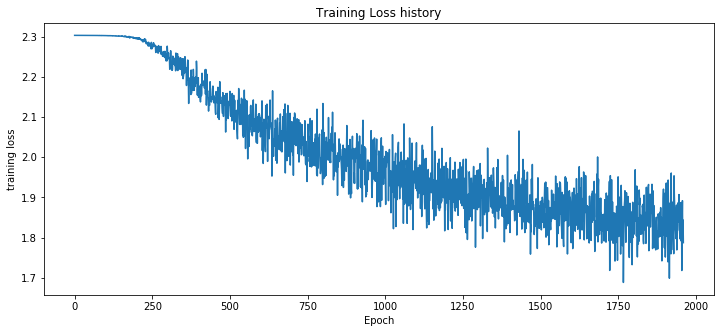

In [47]:
loss, train_acc, val_acc = history

plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

Visualize the training and validation accuracy

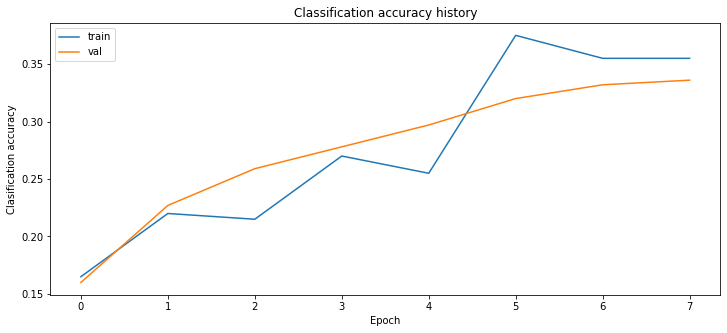

In [48]:
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

### d. Training Accuracy
Calculate the Training Accuracy

In [49]:
import sklearn
from sklearn.metrics import accuracy_score

y_pred = predict_two_layer_relu(X_train, W_relu, b_relu)
accuracy = sklearn.metrics.accuracy_score(y_train, y_pred)

print('Training Accuracy =',accuracy*100,'%')

print('Training label  =',y_train[:15])
print('Predicted label =',y_pred[:15])

Training Accuracy = 34.720408163265304 %
Training label  = [6 9 9 4 1 1 2 7 8 3 4 7 7 2 9]
Predicted label = [6 1 9 6 9 6 4 7 8 7 6 7 9 3 7]


In [50]:
y_pred = predict_two_layer_relu(X_val, W_relu, b_relu)
accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)
print('Validation Accuracy =', accuracy*100,'%')

print('Validation label =',y_val[:15])
print('Predicted label  =',y_pred[:15])

Validation Accuracy = 33.6 %
Validation label = [8 9 4 9 0 5 0 8 2 3 7 8 9 4 5]
Predicted label  = [8 7 8 7 1 6 0 0 7 5 7 1 9 0 7]


---
# [Part 3] Hyperparameter Tuning

Now, let's build a two-layered Neural Network and train it using CIFAR-10 dataset

**What's wrong?**. 
* Looking at the visualizations above, we see that the loss is decreasing **more or less linearly**, which seems to suggest that the learning rate may be too low. 
* Moreover, there is **no gap between the training and validation** accuracy, suggesting that the model we used has low capacity, and that we should increase its size. 
* On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

<br>

**Tuning**. 
* Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice.
* Below, you should experiment with different values of the various hyperparameters, including **hidden layer size**, **learning rate**, and **regularization strength**. 
* You might also consider tuning the **learning rate decay**, but you should be able to get good performance using the default value.

<br>

**Approximate results**. 
* You should be aim to achieve a classification accuracy of greater than **48% on the validation set**. 
* Our best network gets over 52% on the validation set.

In [51]:
import warnings
import datetime
warnings.filterwarnings('ignore')

results = {}
best_val = -1
best_reg = 0
best_lr = 0

best_W = None
best_b = None
max_epoch = 3
max_trial = 30

for trial in range(max_trial):
    
    reg = 10**np.random.uniform(-2, 1)    # <---------- you can try and change this <----------
    lr = 10**np.random.uniform(-2,-4)     # <---------- you can try and change this <----------    
    hidden_size = 200                     # <---------- you can try and change this <----------    
    
    W, b, H = train_two_layer_relu(X_train, y_train, X_val, y_val, hidden_size,
                                      epochs=max_epoch, batch_size=200, 
                                      lr=lr, lr_decay=0.9, 
                                      reg=reg, verbose=False) 
    val_acc = (predict_two_layer_relu(X_val, W, b) == y_val).mean() 
    if val_acc > best_val: 
        best_W = W 
        best_b = b 
        best_val = val_acc 
        best_lr  = lr 
        best_reg = reg 
    print(str(datetime.datetime.now()), ', val_acc:', val_acc, '\tlr:', lr, 
          '\treg:', reg, '\t', str(trial)+'/'+str(max_trial))
    
print ("best regularizer  : ", best_reg)
print ("best learning rate: ", best_lr)

2019-09-26 07:40:15.075152 , val_acc: 0.087 	lr: 0.004179949195757405 	reg: 0.07964004517400487 	 0/30
2019-09-26 07:40:43.813856 , val_acc: 0.087 	lr: 0.004483433256394062 	reg: 0.08048237838274962 	 1/30
2019-09-26 07:41:12.488512 , val_acc: 0.458 	lr: 0.0006297098568011295 	reg: 0.06273252852691488 	 2/30
2019-09-26 07:41:41.445579 , val_acc: 0.285 	lr: 0.00010745725158318461 	reg: 1.2809033302650632 	 3/30
2019-09-26 07:42:08.440551 , val_acc: 0.314 	lr: 0.00014454706415002256 	reg: 0.025008285955228984 	 4/30
2019-09-26 07:42:34.455430 , val_acc: 0.087 	lr: 0.008354786558043168 	reg: 0.31698353871112134 	 5/30
2019-09-26 07:43:00.435318 , val_acc: 0.087 	lr: 0.009939166408976303 	reg: 0.14384044884792038 	 6/30
2019-09-26 07:43:27.703265 , val_acc: 0.429 	lr: 0.003132578395518806 	reg: 0.07177345300249231 	 7/30
2019-09-26 07:43:58.947636 , val_acc: 0.446 	lr: 0.00048335786306421625 	reg: 0.12260077215502958 	 8/30
2019-09-26 07:44:27.795499 , val_acc: 0.415 	lr: 0.000336675851977

---
## 2 - Train the Network Fully

When you are done experimenting,

Train the network for longer epochs using the best **`learning rate`** and best **`regularization strength`**

In [52]:
print ("regularizer  : ", best_reg)
print ("learning rate: ", best_lr)

best_W, best_b, history = train_two_layer_relu(X_train, y_train, X_val, y_val,
                                               W = best_W, b = best_b,
                                               hidden_size=50, epochs=15, 
                                               lr = best_lr, reg = best_reg)

regularizer  :  0.07734571080309492
learning rate:  0.0009841141790192776
iteration 100 (epoch 0 / 15 ): loss = 1.464860664552577
iteration 200 (epoch 0 / 15 ): loss = 1.5444897721651167
iteration 300 (epoch 1 / 15 ): loss = 1.4829416958032835
iteration 400 (epoch 1 / 15 ): loss = 1.3868163729838412
iteration 500 (epoch 2 / 15 ): loss = 1.2458581624791
iteration 600 (epoch 2 / 15 ): loss = 1.3316107023503723
iteration 700 (epoch 2 / 15 ): loss = 1.3981760175370772
iteration 800 (epoch 3 / 15 ): loss = 1.4462445955562757
iteration 900 (epoch 3 / 15 ): loss = 1.4057807363373858
iteration 1000 (epoch 4 / 15 ): loss = 1.3520596433719396
iteration 1100 (epoch 4 / 15 ): loss = 1.2327142481860016
iteration 1200 (epoch 4 / 15 ): loss = 1.2452106104441052
iteration 1300 (epoch 5 / 15 ): loss = 1.182954882757016
iteration 1400 (epoch 5 / 15 ): loss = 1.255864200499756
iteration 1500 (epoch 6 / 15 ): loss = 1.106942468307183
iteration 1600 (epoch 6 / 15 ): loss = 1.2231030278626192
iteration 1700

Visualize the loss

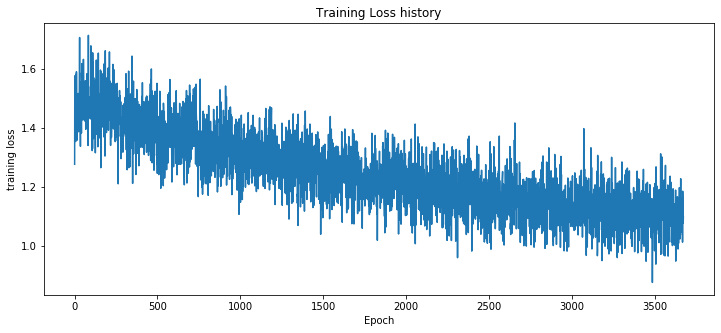

In [53]:
loss, train_acc, val_acc = history
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

Visualize the training and validation accuracy

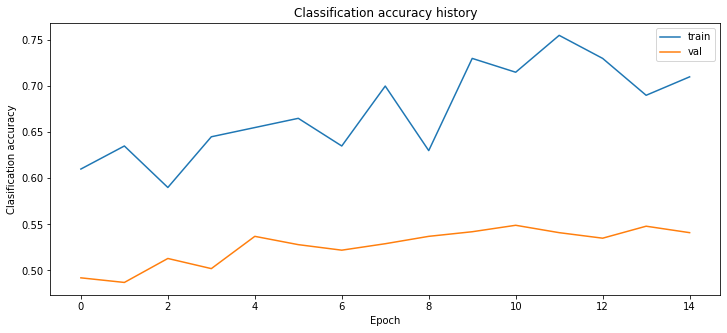

In [54]:
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

---
## 3 - Accuracy and Visualization
Calculate the Training Accuracy

In [55]:
import sklearn
from sklearn.metrics import accuracy_score

y_pred = predict_two_layer_relu(X_train, best_W, best_b)
accuracy = sklearn.metrics.accuracy_score(y_train, y_pred)

print('Training Accuracy =',accuracy*100,'%')

print('Training label  =',y_train[:15])
print('Predicted label =',y_pred[:15])

Training Accuracy = 66.65714285714286 %
Training label  = [6 9 9 4 1 1 2 7 8 3 4 7 7 2 9]
Predicted label = [6 9 9 4 1 7 6 7 8 7 4 7 7 2 9]


In [56]:
y_pred = predict_two_layer_relu(X_val, best_W, best_b)
accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)
print('Validation Accuracy =', accuracy*100,'%')

print('Validation label =',y_val[:15])
print('Predicted label  =',y_pred[:15])

Validation Accuracy = 54.1 %
Validation label = [8 9 4 9 0 5 0 8 2 3 7 8 9 4 5]
Predicted label  = [8 5 0 2 7 3 0 8 7 3 7 9 9 8 7]


plt.imshow(visualize_grid(best_W[0].reshape(32, 32, 3, -1).transpose(3, 0, 1, 2), padding=3).astype('uint8'))

plt.gca().axis('off')
plt.show()

---
## 4 - Test the Trained Weights

Evaluate your final trained network on the test set; you should be able get **above 48%.**

In [57]:
y_pred = predict_two_layer_relu(X_test, best_W, best_b)

accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

print('Testing Accuracy =', accuracy*100,'%')
print('Test label       =',y_test[:15])
print('Predicted label  =',y_pred[:15])

Testing Accuracy = 53.13 %
Test label       = [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9]
Predicted label  = [3 9 0 4 4 6 3 6 3 1 0 1 7 7 9]


---
## 5 - Missclassified Images
An important way to gain intuition about how an algorithm works is to visualize the mistakes that it makes. 
 
 In this visualization, we show examples of images that are misclassified by our current system. 
 
 The first column  shows images that our system labeled as "plane" but whose true label is  something other than "plane".



    missclassified images



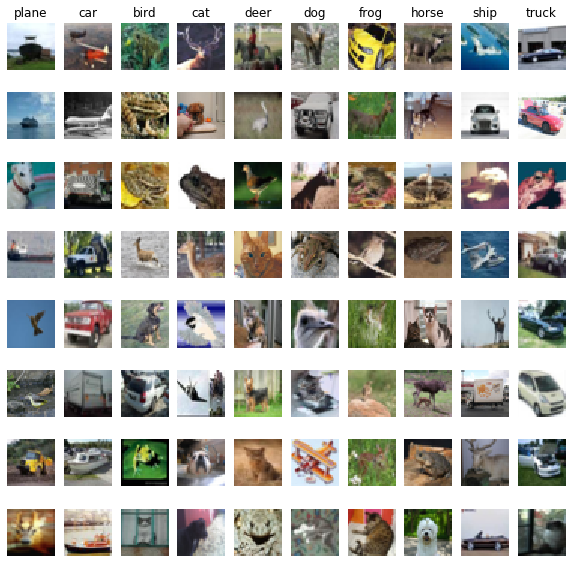

In [58]:
plt.rcParams['figure.figsize'] = [10, 10]

print('\n\n    missclassified images\n')
examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test_ori[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

---
---
# [Optional] Two-Layer NeuralNet on Feature Space

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [59]:
from __future__ import print_function

from scipy.ndimage import uniform_filter

## 1 - Feature Extraction Functions
* For each image we will compute a Histogram of Oriented Gradients (HOG) as well as a color histogram using the hue channel in HSV color space. We form our final feature vector for each image by concatenating the HOG and color histogram feature vectors.

* Roughly speaking, HOG should capture the texture of the image while ignoring color information, and the color histogram represents the color of the input image while ignoring texture. 
* As a result, we expect that using both together ought to work better than using either alone. Verifying this assumption would be a good thing to try for your interests.

* The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image.
* The `extract_features` function takes a set of images and a list of feature functions and evaluates each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [60]:
def extract_features(imgs, feature_fns, verbose=False):
    num_images = imgs.shape[0]
    if num_images == 0:
        return np.array([])

    # Use the first image to determine feature dimensions
    feature_dims = []
    first_image_features = []
    for feature_fn in feature_fns:
        feats = feature_fn(imgs[0].squeeze())
        assert len(feats.shape) == 1, 'Feature functions must be one-dimensional'
        feature_dims.append(feats.size)
        first_image_features.append(feats)

    # Now that we know the dimensions of the features, we can allocate a single
    # big array to store all features as columns.
    total_feature_dim = sum(feature_dims)
    imgs_features = np.zeros((num_images, total_feature_dim))
    imgs_features[0] = np.hstack(first_image_features).T

    # Extract features for the rest of the images.
    for i in range(1, num_images):
        idx = 0
        for feature_fn, feature_dim in zip(feature_fns, feature_dims):
            next_idx = idx + feature_dim
            imgs_features[i, idx:next_idx] = feature_fn(imgs[i].squeeze())
            idx = next_idx
        if verbose and i % 1000 == 0:
            print('Done extracting features for %d / %d images' % (i, num_images))

    return imgs_features

In [61]:
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.144])

In [62]:
def hog_feature(im):

    # convert rgb to grayscale if needed
    if im.ndim == 3:
        image = rgb2gray(im)
    else:
        image = np.at_least_2d(im)

    sx, sy = image.shape  # image size
    orientations = 9  # number of gradient bins
    cx, cy = (8, 8)  # pixels per cell

    gx = np.zeros(image.shape)
    gy = np.zeros(image.shape)
    gx[:, :-1] = np.diff(image, n=1, axis=1)  # compute gradient on x-direction
    gy[:-1, :] = np.diff(image, n=1, axis=0)  # compute gradient on y-direction
    grad_mag = np.sqrt(gx ** 2 + gy ** 2)  # gradient magnitude
    grad_ori = np.arctan2(gy, (gx + 1e-15)) * (180 / np.pi) + 90  # gradient orientation

    n_cellsx = int(np.floor(sx / cx))  # number of cells in x
    n_cellsy = int(np.floor(sy / cy))  # number of cells in y
    # compute orientations integral images
    orientation_histogram = np.zeros((n_cellsx, n_cellsy, orientations))
    for i in range(orientations):
        # create new integral image for this orientation
        # isolate orientations in this range
        temp_ori = np.where(grad_ori < 180 / orientations * (i + 1),
                            grad_ori, 0)
        temp_ori = np.where(grad_ori >= 180 / orientations * i,
                            temp_ori, 0)
        # select magnitudes for those orientations
        cond2 = temp_ori > 0
        temp_mag = np.where(cond2, grad_mag, 0)
        orientation_histogram[:, :, i] = uniform_filter(temp_mag, size=(cx, cy))[int(cx / 2)::cx, int(cy / 2)::cy].T

    return orientation_histogram.ravel()

In [63]:
def color_histogram_hsv(im, nbin=10, xmin=0, xmax=255, normalized=True):
    ndim = im.ndim
    bins = np.linspace(xmin, xmax, nbin + 1)
    hsv = matplotlib.colors.rgb_to_hsv(im / xmax) * xmax
    imhist, bin_edges = np.histogram(hsv[:, :, 0], bins=bins, density=normalized)
    imhist = imhist * np.diff(bin_edges)

    # return histogram
    return imhist

## 2 - Reload the CIFAR-10 dataset

In [64]:
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

mask = list(range(49000, 50000))
X_val = X_train[mask]
y_val = y_train[mask]
mask = list(range(49000))
X_train = X_train[mask]
y_train = y_train[mask]

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'forse', 'ship', 'truck']

Clear previously loaded data.


## 3 - Extract Features

In [65]:
num_color_bins = 20 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]

X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [66]:
y_train = y_train.ravel()
y_val = y_val.ravel()
y_test = y_test.ravel()

print('X_train_feats.shape =', X_train_feats.shape)
print('y_train.shape =',y_train.shape)
print('y_val.shape   =',y_val.shape)
print('y_test.shape  =',y_test.shape)

X_train_feats.shape = (49000, 165)
y_train.shape = (49000,)
y_val.shape   = (1000,)
y_test.shape  = (10000,)


Again, fine tune the network, and find the best hyperparameter (learning rate, regularizations, bins, hidden neuron, etc)

Then train the network once again using feature space CIFAR10 dataset

In [67]:
W, b, H = train_two_layer_relu(X_train_feats, y_train, X_val_feats, y_val,
                               hidden_size=100, epochs=10,
                               lr = 0.9, reg = 0.0)

iteration 100 (epoch 0 / 10 ): loss = 1.4179968177851907
iteration 200 (epoch 0 / 10 ): loss = 1.5439049188213074
iteration 300 (epoch 1 / 10 ): loss = 1.2845230893878812
iteration 400 (epoch 1 / 10 ): loss = 1.3518329790761385
iteration 500 (epoch 2 / 10 ): loss = 1.175435967723426
iteration 600 (epoch 2 / 10 ): loss = 1.1714424003057624
iteration 700 (epoch 2 / 10 ): loss = 1.1500016223234528
iteration 800 (epoch 3 / 10 ): loss = 1.0754721937797433
iteration 900 (epoch 3 / 10 ): loss = 1.3328508020242504
iteration 1000 (epoch 4 / 10 ): loss = 1.218681853958134
iteration 1100 (epoch 4 / 10 ): loss = 0.8910081630218818
iteration 1200 (epoch 4 / 10 ): loss = 1.0400453121533308
iteration 1300 (epoch 5 / 10 ): loss = 0.8590569056262055
iteration 1400 (epoch 5 / 10 ): loss = 0.9663987555967009
iteration 1500 (epoch 6 / 10 ): loss = 1.0318342364017161
iteration 1600 (epoch 6 / 10 ): loss = 0.9879712263583983
iteration 1700 (epoch 6 / 10 ): loss = 0.9214016142393763
iteration 1800 (epoch 7 /

This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; 

our best model achieves **about 60% classification accuracy**.

In [68]:
y_pred = predict_two_layer_relu(X_val_feats, W, b)

accuracy = sklearn.metrics.accuracy_score(y_val, y_pred)

print('Validation Accuracy =', accuracy*100,'%')
print('Test label          =',y_val[:15])
print('Predicted label     =',y_pred[:15])

Validation Accuracy = 59.5 %
Test label          = [8 9 4 9 0 5 0 8 2 3 7 8 9 4 5]
Predicted label     = [8 6 3 9 0 3 0 8 2 3 7 9 9 5 6]


In [69]:
y_pred = predict_two_layer_relu(X_test_feats, W, b)

accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)

print('Testing Accuracy =', accuracy*100,'%')
print('Test label       =',y_test[:15])
print('Predicted label  =',y_pred[:15])

Testing Accuracy = 57.47 %
Test label       = [3 8 8 0 6 6 1 6 3 1 0 9 5 7 9]
Predicted label  = [3 8 8 1 6 4 6 4 3 9 0 9 4 7 9]


---
## 5 - Missclassified Images
An important way to gain intuition about how an algorithm works is to visualize the mistakes that it makes. 
 
 In this visualization, we show examples of images that are misclassified by our current system. 
 
 The first column  shows images that our system labeled as "plane" but whose true label is  something other than "plane".



    missclassified images



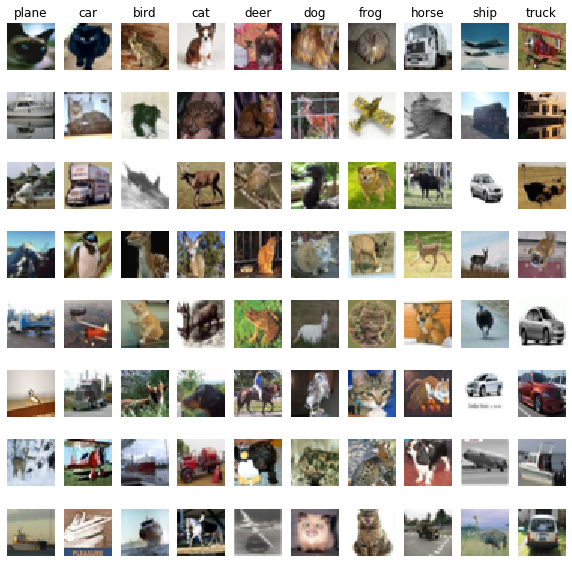

In [70]:
plt.rcParams['figure.figsize'] = [10, 10]

print('\n\n    missclassified images\n')
examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test_ori[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()